# Helmholtz 1D: Building The Multilevel Hierarchy, Step-by-Step
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size to $4$ points. Consider a certain aggregate in the domain (say, the first one).
* Observe beahviour vs. $\nu$:
  * Create relaxed TVs with $\nu$ Kaczmarz relaxation sweeps.
  * Create the coarsening operator $R$ using SVD. Observe singular value decay rate.
  * Observe two-level mini-cycle convergence factor before slowing down.

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

In [123]:
def check_coarsening(level, aggregate_size: int = 4):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 3 * len(num_sweeps_values)))
    for row, num_sweeps in enumerate(num_sweeps_values):
        # Create relaxed TVs.
        x = hm.solve.run.run_iterative_method(
            level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

        start, end = 0, aggregate_size
        x_aggregate_t = x[start:end].transpose()
        r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
        r = r.asarray()

        # Relaxed vectors.
        ax = axs[row, 0]
        for i in range(3):
            ax.plot(x[:, i]);
        ax.grid(True)
        ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        for i, ri in enumerate(np.real(r)):
            ax.plot(ri)
        ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
        ax.set_ylabel(r"$R$ rows")
        ax.grid(True);

        # Singular values, normalized to sigma_max = 1.
        ax = axs[row, 2]
        ax.plot(s / s[0], "rx")
        ax.set_title("Singular Values")
        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"$\sigma_k$")
        ax.grid(True);

        print("nu", "{:2d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

        # Generate coarse variables (R) on the non-repetitive domain.
        r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x, threshold=threshold,
                                                                                           fixed_aggregate_size=aggregate_size)
        _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
        _LOGGER.info("nc  {}".format(nc))
        _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
        mock_conv_factor = np.array(
            [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
        _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [124]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

kh 0
INFO         0 |r| 1.39370600e+00 RER 3.11760
INFO         1 |r| 7.66707525e-01 (0.55073) RER 2.30475 (0.73942) 0.33305
INFO         2 |r| 4.45513640e-01 (0.58155) RER 1.60254 (0.69584) 0.27845
INFO         3 |r| 2.78266633e-01 (0.62467) RER 1.11420 (0.69568) 0.25011
INFO         4 |r| 1.91225244e-01 (0.68690) RER 0.82019 (0.73603) 0.23348
INFO         5 |r| 1.43272431e-01 (0.74877) RER 0.64535 (0.78651) 0.22233
INFO         6 |r| 1.15647173e-01 (0.80650) RER 0.54096 (0.83762) 0.21411
INFO         7 |r| 9.78757314e-02 (0.84568) RER 0.47227 (0.87224) 0.20762
INFO         8 |r| 8.57826452e-02 (0.87606) RER 0.42497 (0.89925) 0.20229
INFO         9 |r| 7.69986718e-02 (0.89742) RER 0.39022 (0.91801) 0.19777
INFO        10 |r| 7.01772354e-02 (0.91142) RER 0.36283 (0.92991) 0.19385
INFO        11 |r| 6.46752116e-02 (0.92169) RER 0.34042 (0.93845) 0.19040
INFO        12 |r| 6.01222645e-02 (0.92968) RER 0.32162 (0.94500) 0.18732
INFO        13 |r| 5.62873695e-02 (0.93624) RER 0.30558 (0.95

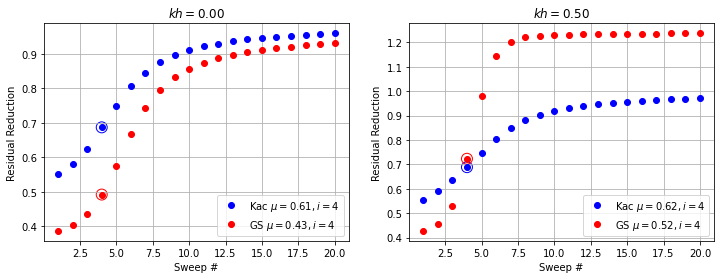

In [128]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} residual-per-sweep {:.2f}".format(
            title, np.mean(residual[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

### Coarsening Quality
We measure the gap between the second and third singular values as a function of the number of TV relaxation sweeps $\nu$. We force the aggregate size to be $4$.

In [125]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

nu  5 s [1.    0.914 0.185 0.071] Energy error [0.683 0.145 0.052 0.   ]
INFO     Agg [4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3]
INFO     nc  [3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2]
INFO     Energy error mean 0.0548 max 0.0860
INFO     Mock cycle conv factor [0.322 0.255 0.096 0.079 0.04  0.021 0.014 0.006 0.004 0.004 0.004 0.004 0.004 0.004 0.003]
nu 10 s [1.    0.823 0.18  0.041] Energy error [0.645 0.141 0.031 0.   ]
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
INFO     Energy error mean 0.0215 max 0.0322
INFO     Mock cycle conv factor [0.314 0.283 0.094 0.08  0.043 0.021 0.018 0.005 0.004 0.003 0.003 0.002 0.002 0.001 0.001]
nu 20 s [1.    0.737 0.154 0.013] Energy error [0.602 0.123 0.011 0.   ]
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [3 2 3 3 3 2 2 3 2 2 3 3 3 3 3 3 2 3 3 3 3 2 3 3]
INFO     Energy error mean 0.0341 max 0.0970
INFO     Mock cy

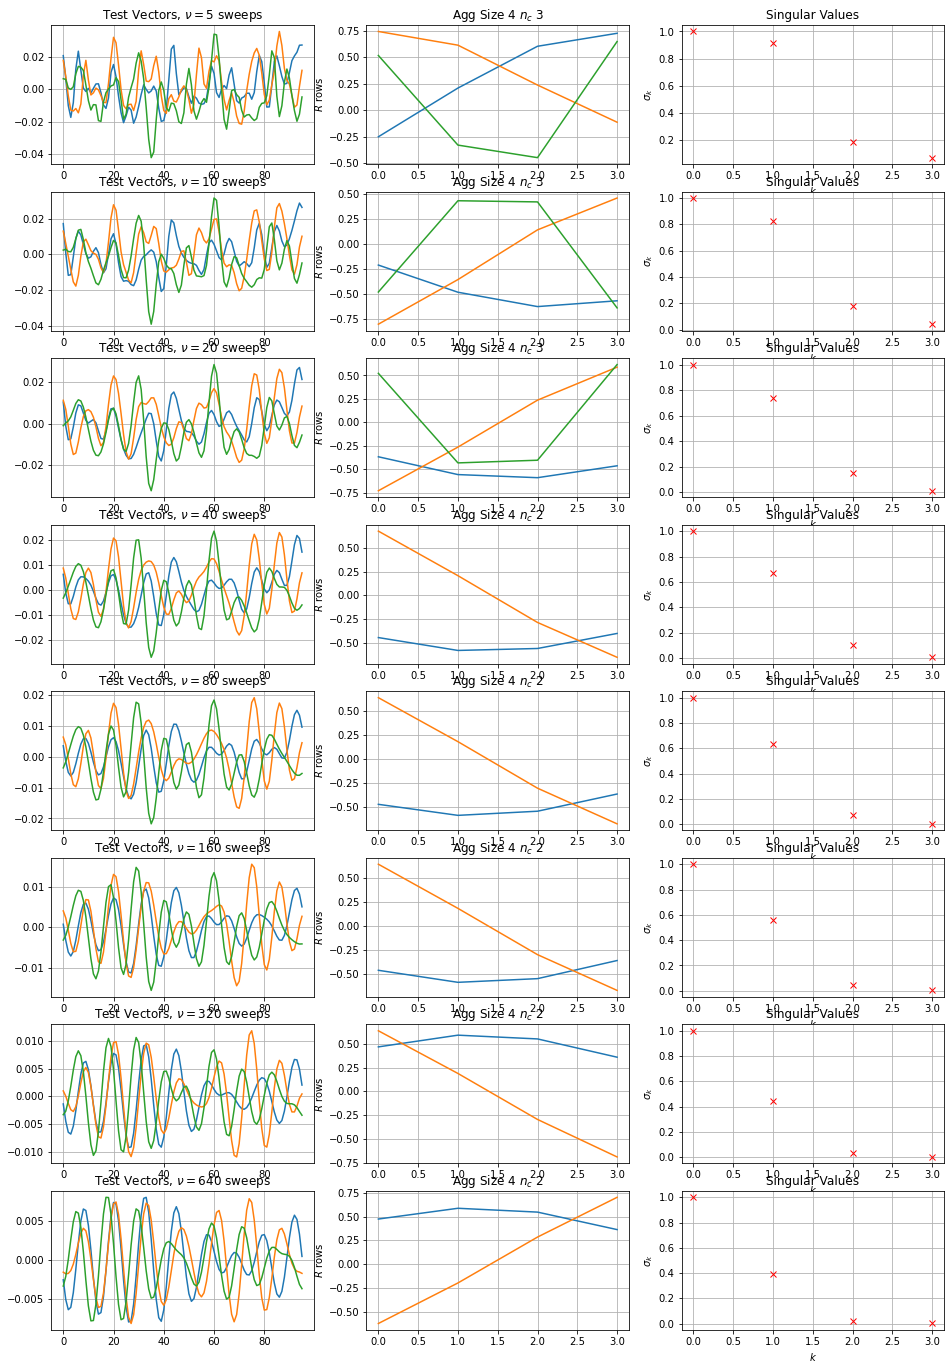

In [126]:
check_coarsening(level, 4)

nu  5 s [1.    0.818 0.6   0.207 0.091 0.043] Energy error [0.721 0.445 0.159 0.07  0.03  0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
INFO     nc  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     Energy error mean 0.0701 max 0.0911
INFO     Mock cycle conv factor [0.386 0.235 0.143 0.073 0.058 0.024 0.02  0.011 0.007 0.006 0.008 0.006 0.006 0.005 0.005]
nu 10 s [1.    0.869 0.576 0.136 0.024 0.006] Energy error [0.725 0.408 0.096 0.017 0.004 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
INFO     nc  [3 3 4 3 3 3 3 4 3 3 3 4 3 3 3 3]
INFO     Energy error mean 0.0759 max 0.0969
INFO     Mock cycle conv factor [0.53  0.276 0.186 0.137 0.093 0.082 0.053 0.034 0.033 0.032 0.024 0.023 0.022 0.017 0.016]
nu 20 s [1.    0.915 0.438 0.079 0.01  0.002] Energy error [0.713 0.312 0.056 0.007 0.001 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
INFO     nc  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
INFO     Energy error mean 0.0550 max 0.0716
INFO     Mock cycle conv factor [0.574 0.283

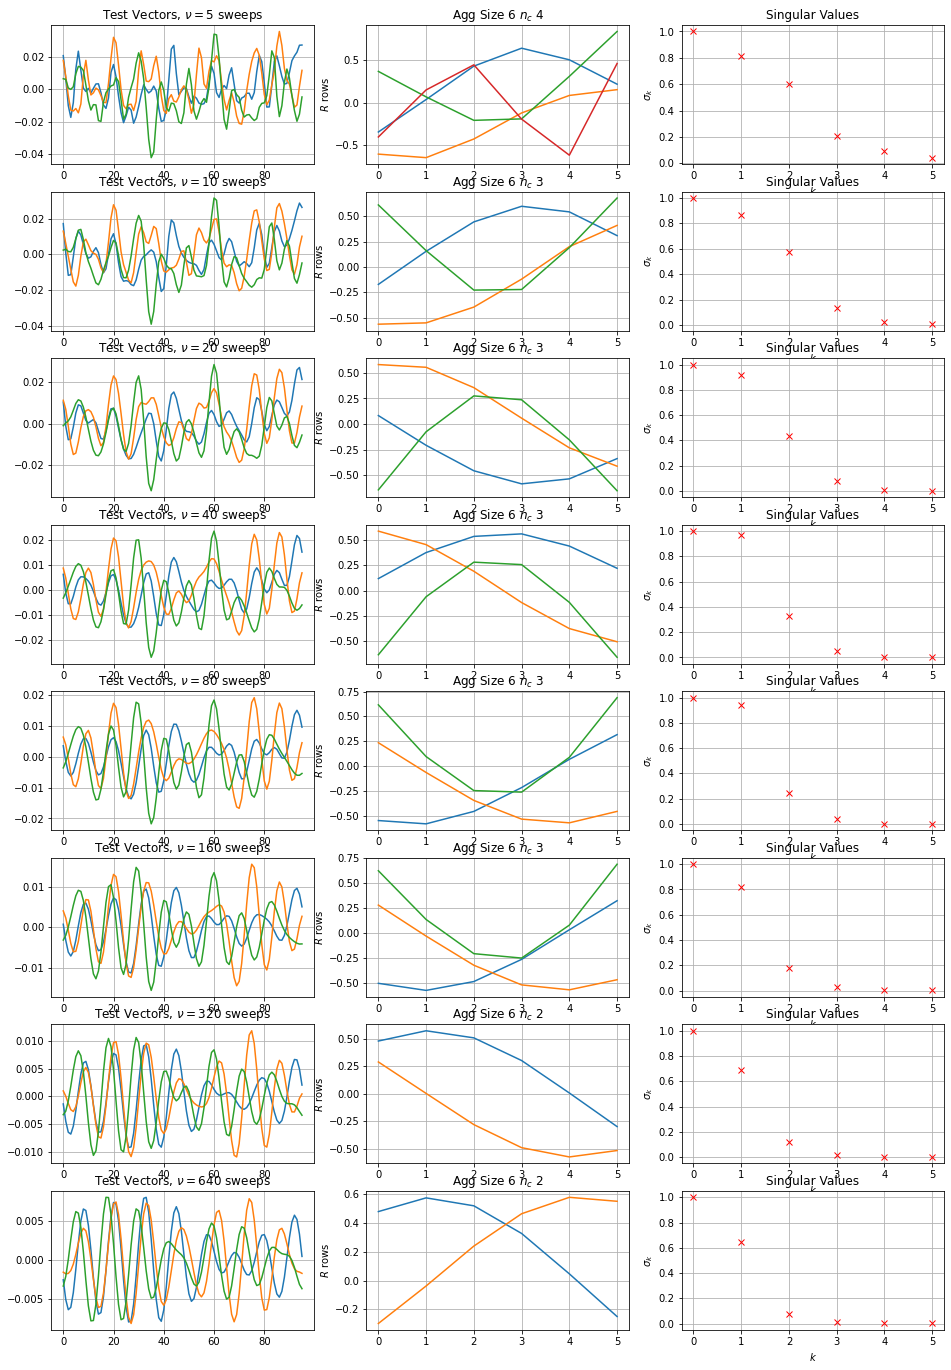

In [127]:
check_coarsening(level, 6)

The gap $\sigma_2 - \sigma_3$ increases with $\nu$, showing that an aggregate size of $4$ is fine (we can obtain an energy error as small as we want given a large enough $\nu$).

### Two-level Bootstrapping

In [103]:
max_levels = 2
num_bootstrap_steps = 1
num_sweeps = 10
fixed_aggregate_size = None # 6

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
        threshold=threshold, fixed_aggregate_size=fixed_aggregate_size)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.989
INFO     Generating TVs with 10 sweeps
INFO     RER 0.308
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.995 asymptotic RQ 0.215 RER 0.241 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 6 4 4 4 1 1]
INFO     nc  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1 1]
INFO     Energy error mean 0.0634 max 0.0966
INFO     Mock cycle conv factor [0.582 0.319 0.192 0.147 0.143 0.123 0.082 0.08  0.068 0.066 0.057]
INFO     P max error: fit 0.046 val 0.049 test 0.118; alpha mean 0.002
INFO     fit  set size 15 P L2 error mean 0.01 max 0.02 A error mean 0.04 max 0.07
INFO     test set size 

### Relaxation Cycle Shrinkage
We compare relaxation cycle with $\nu_1=2, \nu_2=2, \nu_{coarse}=20$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

In [7]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel, nu_coarsest=20)

NameError: name 'multilevel' is not defined

Even though per work unit it is about the same (the mini-cycle is $6$ relaxations worth), the two-level relaxation cycle reduces the RER much more than Kaczmarz until the point of diminishing returns.

As expected, both methods are asymptotically slow (probably the same rate of convergence).

### Effect of a Second Bootstrap Cycle

In [105]:
x, multilevel = hm.setup.auto_setup.bootstap(
    x, multilevel, num_levels, 2.0,
    num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
x_log.append(x)
r_log.append(multilevel.level[1].r)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

INFO     Relax cycle conv factor 0.923 asymptotic RQ -0.016 RER 0.078 P error 0.020
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00
INFO     Agg [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 1]
INFO     nc  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]
INFO     Energy error mean 0.0169 max 0.0496
INFO     Mock cycle conv factor [0.56  0.323 0.187 0.14  0.135 0.121 0.083 0.062 0.062 0.055 0.049]
INFO     P max error: fit 0.025 val 0.019 test 0.034; alpha mean 0.001
INFO     fit  set size 15 P L2 error mean 0.00 max 0.01 A error mean 0.02 max 0.02
INFO     test set size 5  P L2 error mean 0.01 max 0.01 A error mean 0.02 max 0.03
INFO     Level 1 size 49
INFO     RER 0.080


INFO         0 |r| 1.32731494e+00 RER 2.96772
INFO         1 |r| 7.22988229e-01 (0.54556) RER 2.09681 (0.70675) 0.34510
INFO         2 |r| 4.18259141e-01 (0.57915) RER 1.39846 (0.66753) 0.29940
INFO         3 |r| 2.58058274e-01 (0.61733) RER 0.93268 (0.66764) 0.27684
INFO         4 |r| 1.75622596e-01 (0.68065) RER 0.66532 (0.71379) 0.26398
INFO         5 |r| 1.31256716e-01 (0.74737) RER 0.51407 (0.77270) 0.25534
INFO         6 |r| 1.06849988e-01 (0.81374) RER 0.42941 (0.83498) 0.24885
INFO         7 |r| 9.17274863e-02 (0.85823) RER 0.37658 (0.87673) 0.24360
INFO         8 |r| 8.16704452e-02 (0.89005) RER 0.34152 (0.90655) 0.23917
INFO         9 |r| 7.43868212e-02 (0.91059) RER 0.31621 (0.92556) 0.23531
INFO        10 |r| 6.87467874e-02 (0.92407) RER 0.29661 (0.93780) 0.23187
INFO        11 |r| 6.42289086e-02 (0.93432) RER 0.28093 (0.94704) 0.22876
INFO        12 |r| 6.04856725e-02 (0.94181) RER 0.26794 (0.95370) 0.22591
INFO        13 |r| 5.73274145e-02 (0.94793) RER 0.25698 (0.95912) 

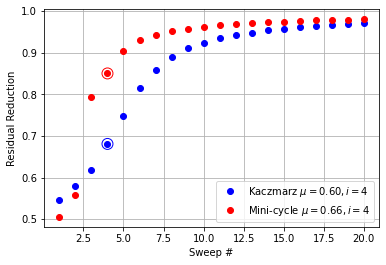

In [106]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel)

Looks like the final RER obtained with a relaxation cycle after one and two bootstrap cycles is the same, so we didn't make it worse.

### Effect of Bootstrap on $R$'s Singular Values

In [107]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x_fit, threshold=threshold)
r_log.append(r)

WARNING  Could not find a good coarsening ratio for aggregate 95:96, n 1 nc 1 cr 1.00


Step  0 s [1.    0.92  0.887 0.582] Energy error [0.815 0.615 0.337 0.   ]
Step  1 s [1.    0.597 0.187 0.036] Energy error [0.531 0.162 0.031 0.   ]
Step  2 s [1.    0.595 0.098 0.008] Energy error [0.516 0.084 0.007 0.   ]
Step  3 s [1.    0.526 0.052 0.003] Energy error [0.467 0.046 0.003 0.   ]


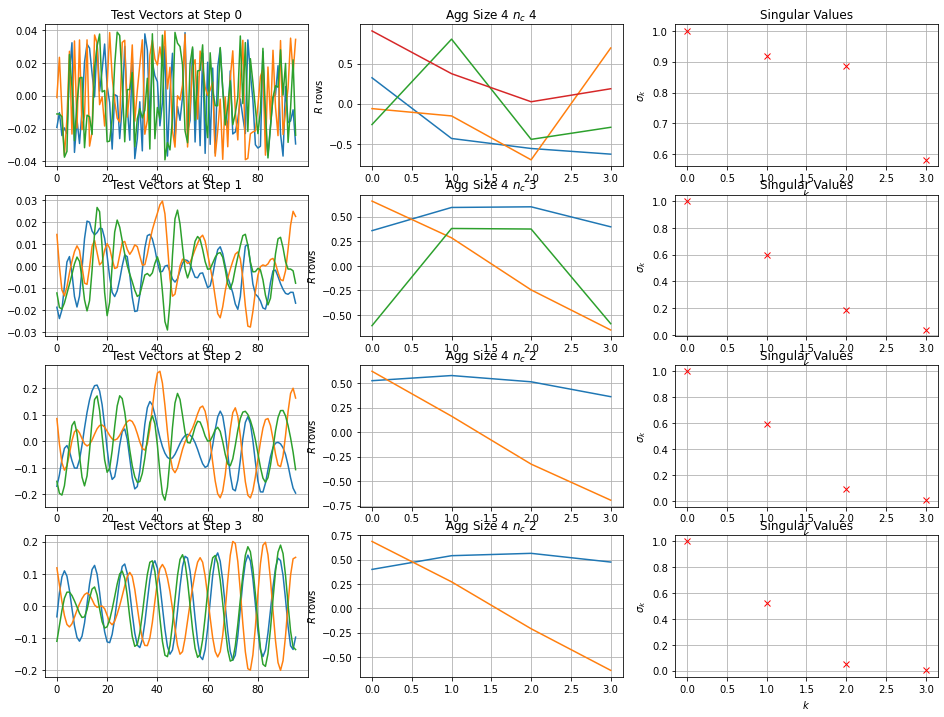

In [108]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

With bootstrap cycles, the smoother the TVs and the better the singular value separation: $R$ is improved.

In [109]:
# Save fine-level TVs.
x_fine = x

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [110]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

### Relaxation Shrinkage Factor

INFO         0 |r| 1.36024482e+02 RER 136.02448
INFO         1 |r| 2.98863623e+01 (0.21971) RER 42.22717 (0.31044) 0.70775
INFO         2 |r| 2.76646715e+01 (0.92566) RER 43.18153 (1.02260) 0.64066
INFO         3 |r| 2.46308758e+01 (0.89034) RER 40.69512 (0.94242) 0.60525
INFO         4 |r| 1.45138051e+01 (0.58925) RER 24.99915 (0.61430) 0.58057
INFO         5 |r| 1.17325034e+01 (0.80837) RER 20.86525 (0.83464) 0.56230
INFO         6 |r| 9.82541273e+00 (0.83745) RER 17.91317 (0.85852) 0.54850
INFO         7 |r| 8.31188501e+00 (0.84596) RER 15.45755 (0.86292) 0.53772
INFO         8 |r| 7.04547404e+00 (0.84764) RER 13.31666 (0.86150) 0.52907
INFO         9 |r| 5.94902487e+00 (0.84438) RER 11.39699 (0.85584) 0.52198
INFO        10 |r| 4.98257402e+00 (0.83754) RER 9.65488 (0.84714) 0.51607
INFO        11 |r| 4.12435701e+00 (0.82776) RER 8.07022 (0.83587) 0.51106
INFO        12 |r| 3.36099158e+00 (0.81491) RER 6.63236 (0.82183) 0.50676
INFO        13 |r| 2.68298432e+00 (0.79827) RER 5.33383

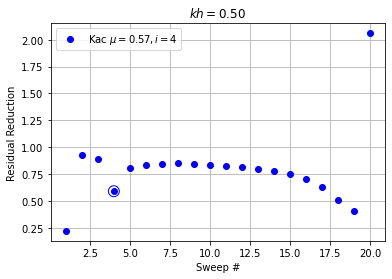

In [111]:
kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Kaczmarz.
operator = lambda x: a.dot(x)
for title, relax, color in zip(("Kac", ), (kaczmarz, ), ("blue", )):
    method = relax(a)
    factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
        operator, lambda x, b: method.step(x, b), (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, num_examples=1)
    hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
    print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
        title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh_value))
ax.legend();

Kaczmarz slows down more quickly here than on level 1. GS diverges.

### $R$ for Aggregate Size = 4

nu  5 s [1.    0.748 0.543 0.027] Energy error [0.679 0.399 0.02  0.   ]
INFO     Agg [4 1 1 4 4 4 4 4 1 4 4 1 4 4 4 1]
INFO     nc  [3 1 1 3 3 3 3 3 1 3 3 1 3 3 3 1]
INFO     Energy error mean 0.0824 max 1.0000
INFO     Mock cycle conv factor [0.202 0.106 0.06  0.034 0.024 0.019 0.015 0.015 0.013 0.012 0.011 0.012 0.007 0.011 0.011]
nu 10 s [1.    0.775 0.504 0.025] Energy error [0.679 0.371 0.018 0.   ]
INFO     Agg [4 1 1 4 4 4 4 4 1 4 4 1 4 4 4 1]
INFO     nc  [3 1 1 3 3 3 3 3 1 3 3 1 3 3 3 1]
INFO     Energy error mean 0.0782 max 1.0000
INFO     Mock cycle conv factor [0.157 0.106 0.057 0.041 0.025 0.019 0.016 0.007 0.012 0.013 0.012 0.012 0.012 0.007 0.011]
nu 20 s [1.    0.822 0.444 0.023] Energy error [0.683 0.325 0.017 0.   ]
INFO     Agg [4 1 1 4 4 4 4 4 1 4 4 1 4 4 4 1]
INFO     nc  [3 1 1 3 3 3 3 3 1 3 3 1 3 3 3 1]
INFO     Energy error mean 0.0762 max 1.0000
INFO     Mock cycle conv factor [0.225 0.106 0.058 0.036 0.027 0.014 0.014 0.013 0.012 0.012 0.012 0.008 0.008 0.01 

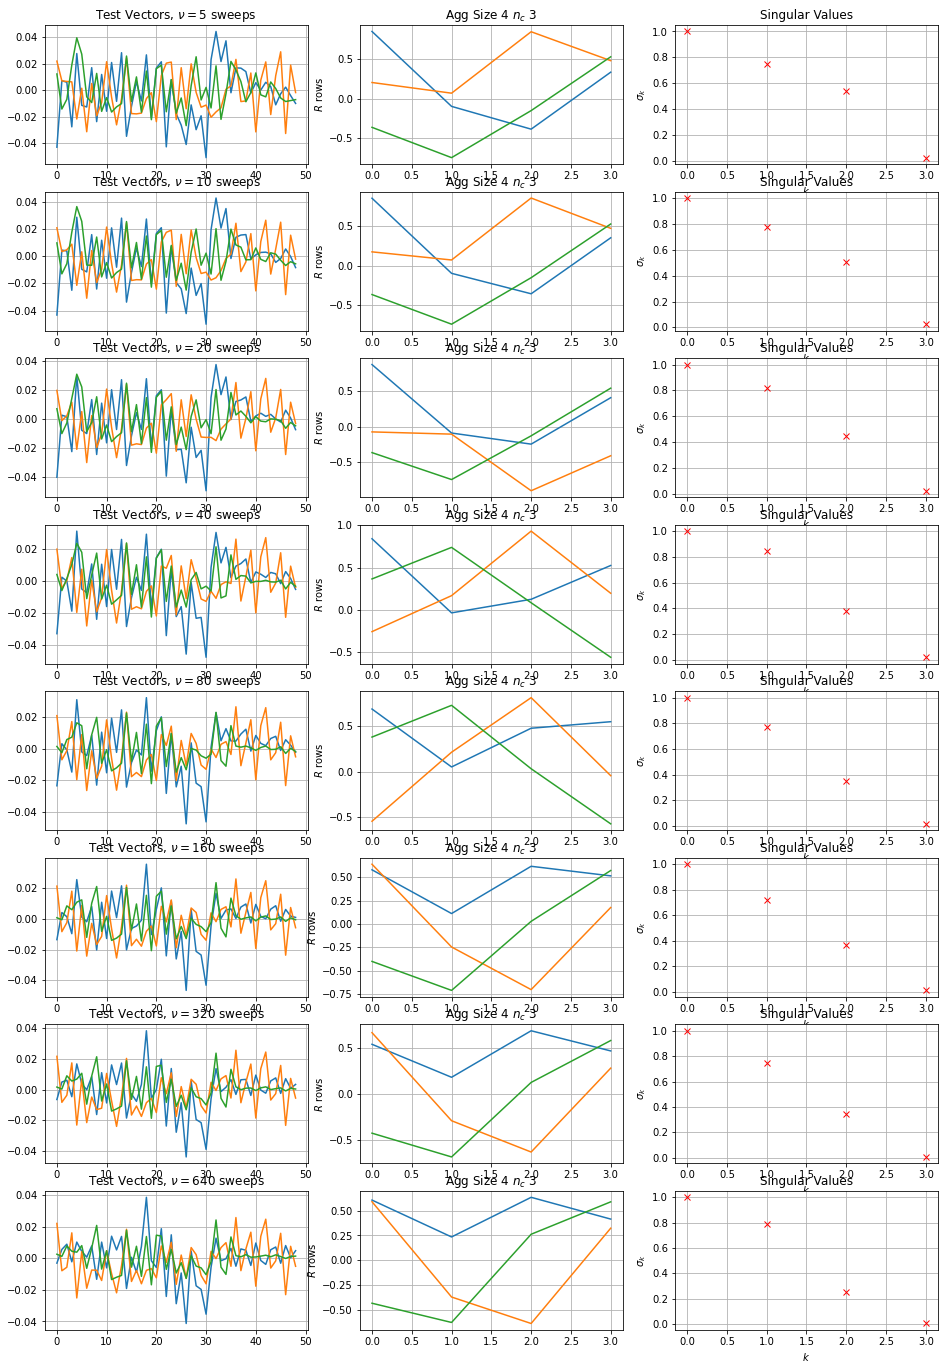

In [112]:
check_coarsening(level, 4)

It looks like it takes a lot more relaxation sweeps to see $2$ components in a size $4$ aggregate here. Mock cycle rates are also worse.

### $R$ for Aggregate Size = 6

nu  5 s [1.    0.82  0.734 0.46  0.063 0.012] Energy error [0.767 0.558 0.298 0.041 0.008 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 4 4 4 5 4 4 4 1]
INFO     Energy error mean 0.1421 max 1.0000
INFO     Mock cycle conv factor [0.353 0.171 0.076 0.027 0.007 0.004 0.005 0.008 0.007 0.005 0.006 0.008 0.005 0.004 0.01 ]
nu 10 s [1.    0.794 0.699 0.41  0.059 0.004] Energy error [0.751 0.537 0.274 0.039 0.003 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 4 4 4 5 4 4 4 1]
INFO     Energy error mean 0.1316 max 1.0000
INFO     Mock cycle conv factor [0.343 0.179 0.07  0.029 0.012 0.012 0.008 0.004 0.004 0.008 0.005 0.005 0.005 0.003 0.003]
nu 20 s [1.    0.785 0.614 0.341 0.05  0.002] Energy error [0.726 0.485 0.237 0.034 0.001 0.   ]
INFO     Agg [6 6 6 6 6 6 6 6 1]
INFO     nc  [4 4 4 4 4 4 4 4 1]
INFO     Energy error mean 0.1361 max 1.0000
INFO     Mock cycle conv factor [0.379 0.17  0.082 0.032 0.02  0.012 0.01  0.011 0.006 0.012 0.011 0.012 0.016 0.011 0.013]
nu 4

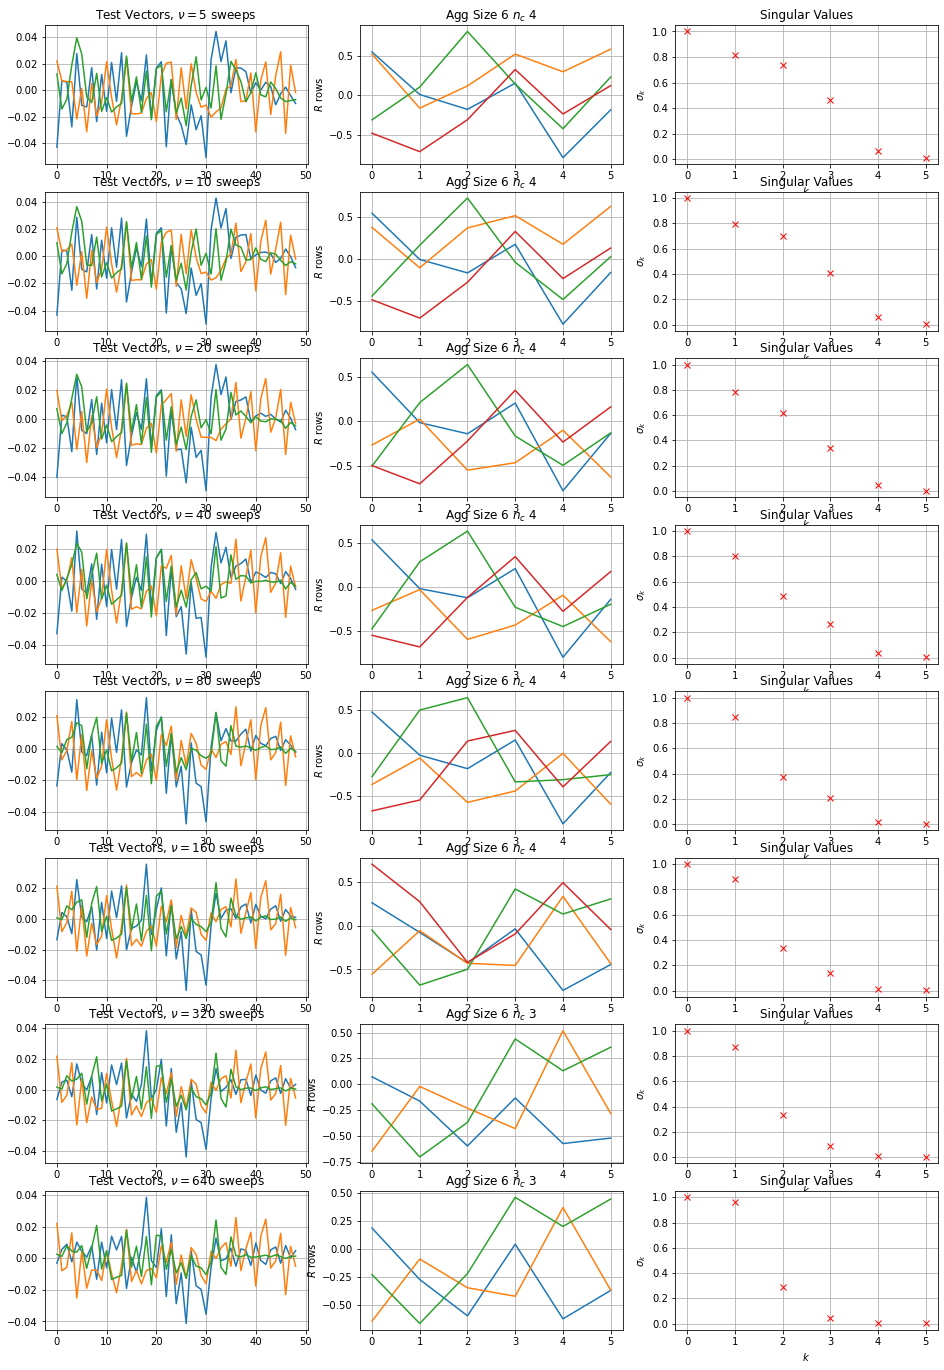

In [113]:
check_coarsening(level, 6)

One can obtain a good coarsening here too (in terms of coarsening ratio and mock cycle rates), with an aggregate size of $6$ and $3$ coarse variables. Note that this requires less smoothing ($\nu = 40$) than for an aggregate size of $4$, where we stll $3$ PCs until $\nu$ is much larger ($320$). Thus, a general criterion would find the larger aggregate size.

The mock cycle rates are worse than for level 0, but we can still obtain improvement when more relaxations per cycle are added. Convergence of $0.2$ is obtained for $11$ relaxations per cycle, as opposed to $3$ at level 0.

### $R$ with Dynamic Aggregate Size

nu  5 s [1.    0.951 0.846 0.818 0.73  0.71  0.668 0.585 0.541 0.506 0.462 0.385 0.356 0.308 0.272 0.25  0.155 0.151 0.093 0.065] Energy error [0.919 0.839 0.77  0.7   0.638 0.573 0.509 0.454 0.401 0.348 0.296 0.254 0.212 0.174 0.138 0.096 0.074 0.045 0.026 0.   ]
WARNING  Could not find a good coarsening ratio for aggregate 6:14, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 14:22, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 22:30, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 30:38, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 38:46, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 48:49, n 1 nc 1 cr 1.00
INFO     Agg [6 8 8 8 8 8 1 1 1]
INFO     nc  [4 5 5 5 5 5 1 1 1]
INFO     Energy error mean 0.0254 max 0.0941
INFO     Mock cycle conv factor [0.482 0.213 0.103 0.038 0.03  0.023 0.026 0.025 0.026 0.014 0.026 0.025 0.02

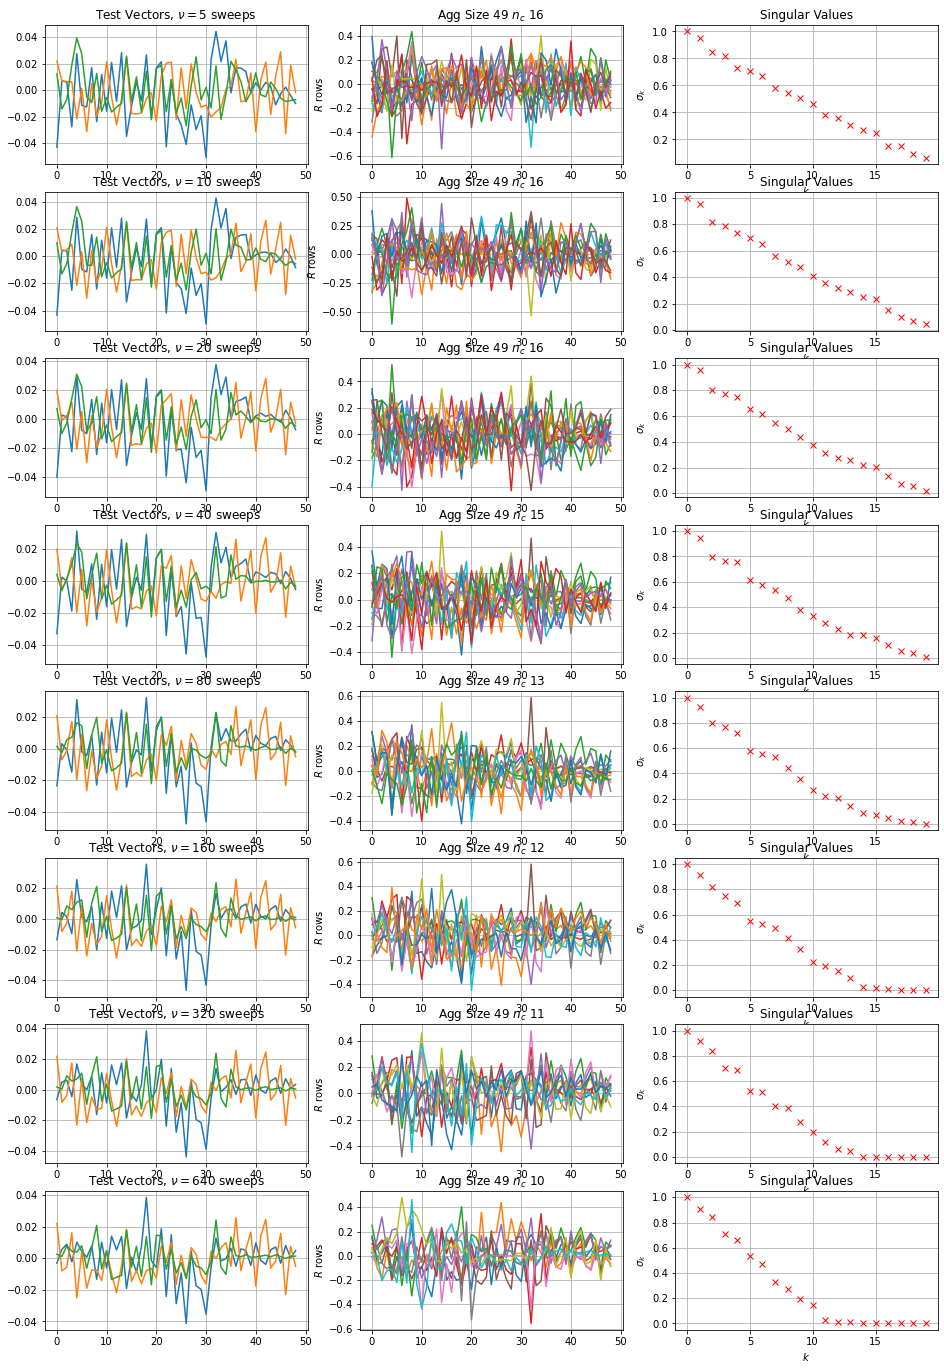

In [114]:
check_coarsening(level, None)

### Two-level Bootstrapping

In [115]:
num_examples = 30
max_levels = 2
num_bootstrap_steps = 3
num_sweeps = 20

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     Relax at level 0 size 49
INFO     Relax convergence factor 0.996
INFO     Generating TVs with 20 sweeps
INFO     RER 4.975
INFO     bootstrap on grid size 49 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.971 asymptotic RQ -0.040 RER 0.505 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
WARNING  Could not find a good coarsening ratio for aggregate 0:8, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 8:16, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 16:24, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 30:38, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 48:49, n 1 nc 1 cr 1.00
INFO     Agg [8 8 8 6 8 4 4 1 1 1]
INFO     nc  [5 5 5 3 5 2 2 1 1 1]
INFO     Energy error mean 0.0234 max 0.

In [116]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x_fit, threshold=threshold)
r_log.append(r)

WARNING  Could not find a good coarsening ratio for aggregate 30:38, n 8 nc 5 cr 0.62
WARNING  Could not find a good coarsening ratio for aggregate 44:49, n 5 nc 3 cr 0.60


Step  0 s [1.    0.681 0.57  0.496] Energy error [0.713 0.53  0.348 0.   ]
Step  1 s [1.    0.796 0.46  0.021] Energy error [0.677 0.339 0.016 0.   ]
Step  2 s [1.    0.637 0.315 0.021] Energy error [0.579 0.257 0.017 0.   ]
Step  3 s [1.    0.567 0.157 0.018] Energy error [0.507 0.136 0.016 0.   ]
Step  4 s [1.    0.524 0.158 0.006] Energy error [0.48  0.139 0.005 0.   ]


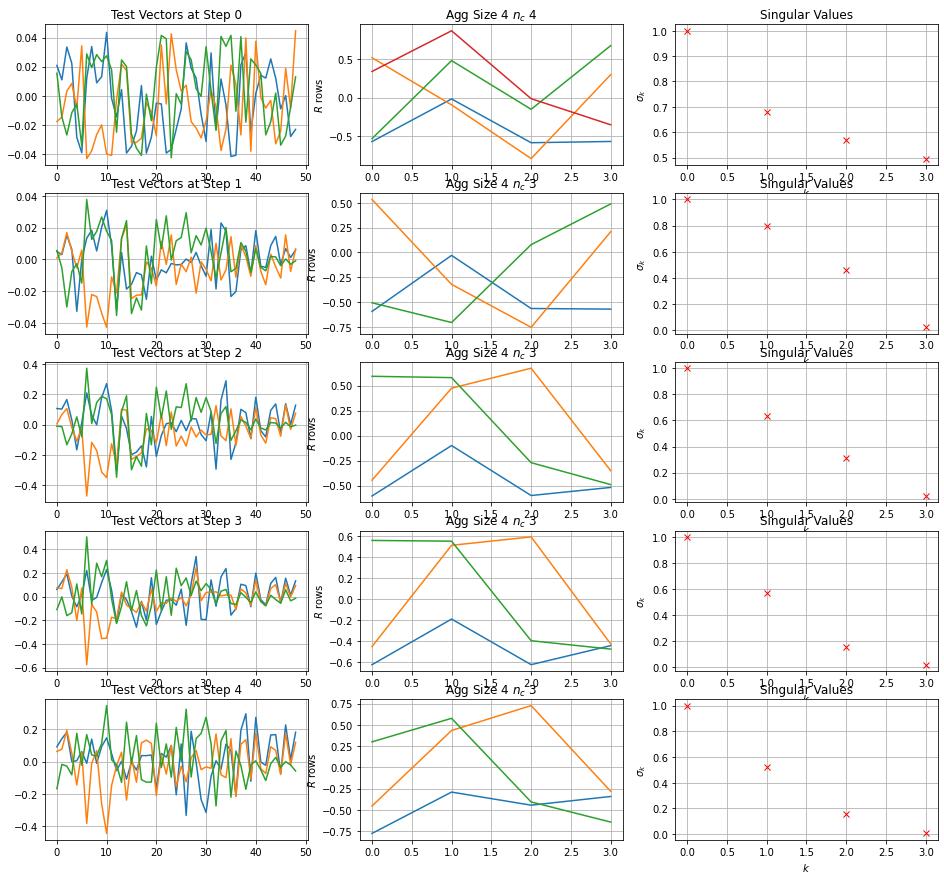

In [117]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

Here we also observe that the singular value gap increases with bootsrap cycles, but no longer monotonically (it is noisy).

INFO         0 |r| 2.27955161e+01 RER 52.57666
INFO         1 |r| 1.47805047e+01 (1.52413) RER 43.31920 (1.96904) 0.34112
Kaczmarz   RER at point of diminishing returns 14.78 num_sweeps  1 work  1 Residual-per-sweep 1.52
INFO         0 |r| 4.02447681e+01 RER 92.26765
INFO         1 |r| 1.47452317e+01 (1.12560) RER 16.07600 (0.57662) 0.94027
INFO         2 |r| 8.24481891e+00 (0.88806) RER 8.21380 (0.86369) 0.99991
INFO         3 |r| 5.16066209e+00 (0.56305) RER 5.05195 (0.55577) 1.01085
INFO         4 |r| 2.91237455e+00 (0.49208) RER 2.82740 (0.48996) 1.01449
INFO         5 |r| 1.75765526e+00 (0.94132) RER 1.71753 (0.94173) 1.01411
INFO         6 |r| 1.13421049e+00 (0.84749) RER 1.12508 (0.84793) 1.01221
INFO         7 |r| 9.25915926e-01 (0.76580) RER 0.92688 (0.76630) 1.01000
INFO         8 |r| 1.28416341e+00 (1.70215) RER 1.28198 (1.70756) 1.00795
Mini-cycle RER at point of diminishing returns 1.28 num_sweeps  8 work  6 Residual-per-sweep 0.95


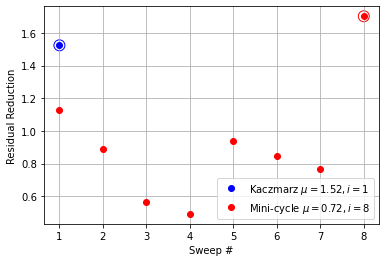

In [118]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel, max_sweeps=100)

## Questions
* Why aren't level 1 TVs getting smoother with bootstrap cycles? Their RER oscillates wildly between cycles even though the interpolation error is good (see cycle 2->3).
* Need a lot more examples (30 instead of 20) on level 1 because apparently there are up to 12 interpolation points in the stencil (if a large enough aggregate is chosen).